#MASK R-CNN

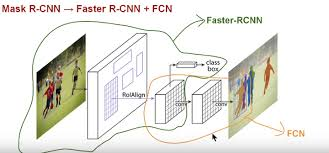

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 32.07 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5


In [3]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:08<00:00, 21.5MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
   '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
   'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
   'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
   'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
   'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
   'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
   'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
   'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
   'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
   'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
   'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(img_path, threshold):
 img = Image.open(img_path)
 transform = T.Compose([T.ToTensor()])
 img = transform(img)
 pred = model([img])
 pred_score = list(pred[0]['scores'].detach().numpy())
 pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
 masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
 pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
 pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
 masks = masks[:pred_t+1]
 pred_boxes = pred_boxes[:pred_t+1]
 pred_class = pred_class[:pred_t+1]
 return masks, pred_boxes, pred_class
def random_colour_masks(image):
 colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
 r = np.zeros_like(image).astype(np.uint8)
 g = np.zeros_like(image).astype(np.uint8)
 b = np.zeros_like(image).astype(np.uint8)
 r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
 coloured_mask = np.stack([r, g, b], axis=2)
 return coloured_mask


In [0]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
 masks, boxes, pred_cls = get_prediction(img_path, threshold)
 img = cv2.imread(img_path)
 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 for i in range(len(masks)):
   rgb_mask = random_colour_masks(masks[i])
   img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
   cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
   cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
 plt.figure(figsize=(20,30))
 plt.imshow(img)
 plt.xticks([])
 plt.yticks([])
 plt.show()

In [0]:
from PIL import Image
import torchvision.transforms as T
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

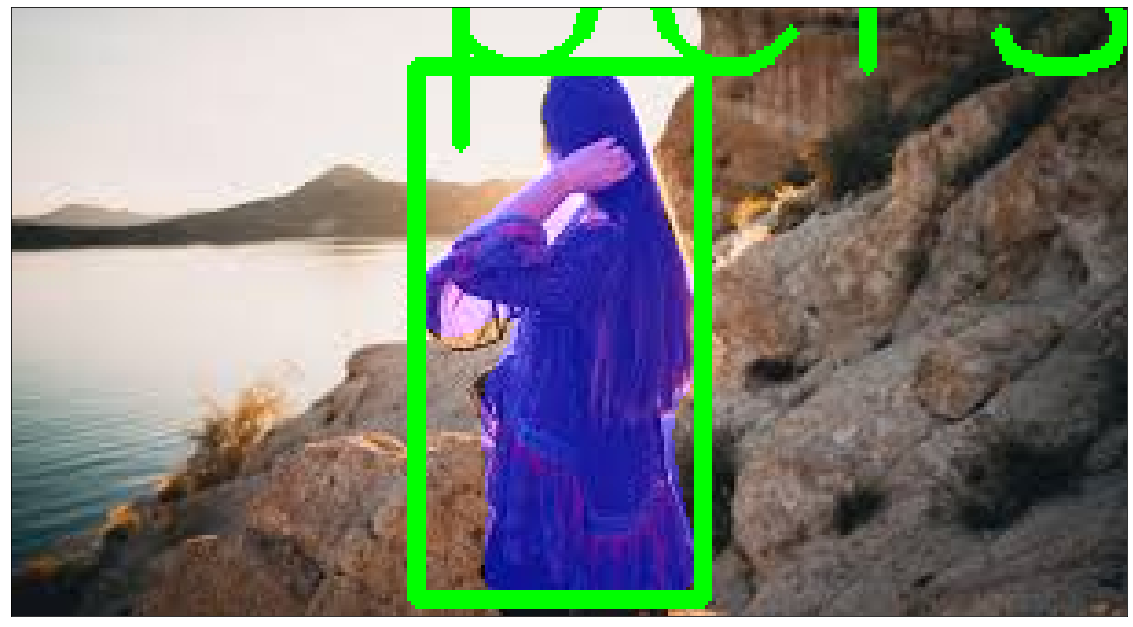

In [9]:
instance_segmentation_api('/content/content.jpg')